<a href="https://colab.research.google.com/github/cirvine26/DIAS_Code/blob/master/Quantum_Control_in_Fermionic_Spin_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Control in Fermionic Spin Chain
After application of Jordan-Wigner transformation to get a quadratic fermionic hamiltonian which maps a system of N qubits to a $2N \times 2N$ density matrix (rather than the standard $2^N \times 2^N$) we can use $Tr(\rho ^2)$ where $\rho$ is the density matrix of the composite system as a means to measure the purity of the state. This also leads to information about the decoherence, as $Tr(\rho ^2) \leq1$ with $Tr(\rho ^2)=1$ corresponding to a pure state. As this measure decreases towards $0$, the state becomes more mixed (Entangled?) and more decoherent. 


Consider using a Gradient Descent algorithm to iterate over the free parameters $\vec{\omega}$ and $\vec{\lambda}$ in the Spin system Hamiltonian. Optimise $Tr(\rho^2)$ to as close to $1$ as possible to find the configuration that preserves the purity of the state. Additionally could find the configuration that causes $Tr(\rho^2)\sim 0$ to find the most decoherent configuration. 

Maybe also considering adding the temperature $T$ and the initial Bloch Vector $\vec{n}$ as features for the ML model to optimise over.

An error function that may be more useful could be the fidelity. This is given by $\left\langle \psi(0) | \rho |\psi(0) \right\rangle$

More interesting to use $Tr(\rho^2)$ and to investigate how the system performs at control towards a pure state as the temperautre is increased.

In [ ]:
'''Imports'''
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm.notebook import tqdm
import scipy.linalg as LA
import time 
np.set_printoptions(precision=3)

In [ ]:
'''Functions from the previous package'''
#Returns the total matrix hamiltonian of the entire system, including the N+1 ghost particle 
def total_hamiltonian(N, omega_matrix, lambda_matrix):
    #Make the needed empty arrays 
    H=np.zeros((2*(N+1),2*(N+1)), dtype=complex)
    alpha = np.zeros((N+1, N+1), dtype=complex)
    beta = np.zeros((N+1, N+1), dtype=complex)
    alpha0 = np.zeros((N, N), dtype=complex)
    beta0 = np.zeros((N, N), dtype=complex)

    #Only 1st omega x and y terms appear in the hamiltonian whereas omega z appears for all qubits 
    lambdaPlus=lambda_matrix[0,:] + 1j*lambda_matrix[1,:]
    lambdaMinus=lambda_matrix[0,:] - 1j*lambda_matrix[1,:]
    omegaZ=omega_matrix[2,:]

    #Coupling constants 
    omega1Plus=omega_matrix[0,0] + 1j*omega_matrix[1,0]
    omega1Minus=omega_matrix[0,0] - 1j* omega_matrix[1,0]
    lambda1Z=lambda_matrix[2,0]

    # Pauli Matrices
    id = np.identity(2)
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)

    #Construct diagonal matrices
    Om = np.diag(omegaZ)
    Lp = np.diag(lambdaPlus)
    Lm = np.diag(lambdaMinus)

    # Define R which is used to easily move elements to the subdiagonal within a matrix
    R = np.zeros((N, N))
    for i in range(N-1):
     R[i][i+1] = 1

    # Make alpha0 and beta0
    alpha0 = -2*Om + Lm@R + np.transpose(np.conj(Lm@R))
    beta0 = (R.T)@Lp - Lp@R

    # Fill alpha
    alpha[0:N, 0:N] = alpha0
    alpha[0, N] = omega1Plus
    alpha[1, N] = lambda1Z.conjugate()
    alpha[N, 0] = omega1Minus
    alpha[N, 1] = lambda1Z

    # Fill beta
    beta[0:N, 0:N] = beta0
    beta[0, N] = omega1Minus
    beta[1, N] = lambda1Z
    beta[N, 0] = -omega1Minus
    beta[N, 1] = -lambda1Z

    # Fill H
    H[0:N+1, 0:N+1] = alpha
    H[0:N+1, N+1:2*(N+1)] = -beta.conj()
    H[N+1:2*(N+1), 0:N+1] = beta
    H[N+1:2*(N+1), N+1:2*(N+1)] = -alpha.conj()

    #Return the completed hamiltonian 
    return H

#Returns the matrix A from the quadratic formulation of the hamiltonian
def covariance_matrix(N, omega_matrix, lambda_matrix, bloch_vector, temperature):
    #Make the needed empty arrays 
    H=np.zeros((2*(N+1),2*(N+1)), dtype=complex)
    alpha = np.zeros((N+1, N+1), dtype=complex)
    beta = np.zeros((N+1, N+1), dtype=complex)
    alpha0 = np.zeros((N, N), dtype=complex)
    beta0 = np.zeros((N, N), dtype=complex)
    #Extra needed matrices from the hamiltonian case
    A = np.zeros((2*(N+1), 2*(N+1)), dtype=complex)
    alphaPrime = np.zeros((N+1, N+1), dtype=complex)
    betaPrime = np.zeros((N+1, N+1), dtype=complex)
    covarianceMatrix=np.zeros((2*(N+1), 2*(N+1)), dtype=complex)

    #Only 1st omega x and y terms appear in the hamiltonian whereas omega z appears for all qubits 
    lambdaPlus=lambda_matrix[0,:] + 1j*lambda_matrix[1,:]
    lambdaMinus=lambda_matrix[0,:] - 1j*lambda_matrix[1,:]
    omegaZ=omega_matrix[2,:]

    #Coupling constants 
    omega1Plus=omega_matrix[0,0] + 1j*omega_matrix[1,0]
    omega1Minus=omega_matrix[0,0] - 1j* omega_matrix[1,0]
    lambda1Z=lambda_matrix[2,0]

    # Pauli Matrices
    id = np.identity(2)
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)

    #Construct diagonal matrices
    Om = np.diag(omegaZ)
    Lp = np.diag(lambdaPlus)
    Lm = np.diag(lambdaMinus)

    #Define inverse temperature
    betaTemperature=1/temperature

    #Bloch components 
    nPlus=bloch_vector[0]+1j*bloch_vector[1]
    nMinus=bloch_vector[0] - 1j*bloch_vector[1]
    nz=bloch_vector[2]

    #Bloch modulus
    n=np.sqrt(bloch_vector[0]**2 + bloch_vector[1]**2 + bloch_vector[2]**2)

    #K factor for pure/mixed states
    K = 0
    if round(LA.norm(n), 15) != 1:
        K = np.arctanh(n)/n
    else:
        #Must manually set the covariance matrix and return it to terminate the function
        covarianceMatrix[0,0] = -nz
        covarianceMatrix[N+1,N+1] = nz
        covarianceMatrix[0,N] = covarianceMatrix[N,N+1] = 0.5*nPlus
        covarianceMatrix[0,2*N+1] = covarianceMatrix[2*N+1,N+1] = -0.5*nPlus
        covarianceMatrix[N,0] = covarianceMatrix[N+1,N] = 0.5*nMinus
        covarianceMatrix[2*N+1,0] = covarianceMatrix[N+1,2*N+1] = -0.5*nMinus
        #Function will terminate here if pure state
        return covarianceMatrix 


    # Define R which is used to easily move elements to the subdiagonal within a matrix
    R = np.zeros((N, N))
    for i in range(N-1):
        R[i][i+1] = 1

    # Make alpha0 and beta0
    alpha0 = -2*Om + Lm@R + np.transpose(np.conj(Lm@R))
    beta0 = (R.T)@Lp - Lp@R

    # Fill alpha
    alpha[0:N, 0:N] = alpha0
    alpha[0, N] = omega1Plus
    alpha[1, N] = lambda1Z.conjugate()
    alpha[N, 0] = omega1Minus
    alpha[N, 1] = lambda1Z

    # Fill beta
    beta[0:N, 0:N] = beta0
    beta[0, N] = omega1Minus
    beta[1, N] = lambda1Z
    beta[N, 0] = -omega1Minus
    beta[N, 1] = -lambda1Z

    # Make alphaPrime and betaPrime to make A
    alphaPrime = betaTemperature*alpha # first copy alpha, multiplied by betaTemperature, and then change entries
    
    alphaPrime[0][0] = 2*K*nz         # Deals with pure states, since if the state is pure, it sets K = 0, 
    alphaPrime[0][1] = 0              # so we don't need any if statements
    alphaPrime[0][N] = -K*nPlus
    alphaPrime[1][0] = 0
    alphaPrime[1][N] = 0
    alphaPrime[N][0] = -K*nMinus
    alphaPrime[N][1] = 0

    betaPrime = betaTemperature*beta # first copy beta, multiplied by betaTemperature, and then change entries
    
    betaPrime[0][N] = -K*nMinus
    betaPrime[0][1] = 0
    betaPrime[1][0] = 0
    betaPrime[1][N] = 0
    betaPrime[N][0] = K*nMinus
    betaPrime[N][1] = 0

    # Fill A
    A[0:N+1, 0:N+1] = alphaPrime
    A[0:N+1, N+1:2*(N+1)] = -betaPrime.conj()
    A[N+1:2*(N+1), 0:N+1] = betaPrime
    A[N+1:2*(N+1), N+1:2*(N+1)] = -alphaPrime.conj()

    # Set covarianceMatrix
    covarianceMatrix[0:2*N + 2, 0:2*N + 2] = -LA.tanhm((1/2)*A)

    #Return the completed hamiltonian 
    return covarianceMatrix

#Evolve the covariance matrix according to th SE and finite difference method
def evolve_lambda(time_array, time_independent_H, initial_matrix):
    #Need to define a tensor to hold each density matrix at time intervals 
    dt=time_array[1]-time_array[0]

    #Need a tensor to hold the density matrices at each time interval
    #Dimension 0 is how many matrices we have; the length of the time array
    #Dimension 1 and 2 are the dimensions of the matrices themselves 
    #Important to declare the dtype as complex such that we don't cast complex values to real ones
    dens_tensor=np.zeros((len(time_array), len(initial_matrix), len(initial_matrix)), dtype=complex)

    #Set both the 0th and 1st elements to the intial density matrix
    dens_tensor[0]=initial_matrix
    dens_tensor[1]=initial_matrix

    #Now iterate over the other elements of the density tensor
    for ii in range(1, len(time_array)-1):
        #Define the commutator for this iteration
        commutator=time_independent_H@dens_tensor[ii] - dens_tensor[ii]@time_independent_H

        #Now apply the finite difference algorithm
        dens_tensor[ii+1]=dens_tensor[ii-1] - 2j*commutator*dt
    #Now return the density tensor
    return dens_tensor

#Give the sigma z expectation value for the system spin
def expt_sigmaZ1(covariance_matrix):
    #Dimension of the covariance matrix has to be 2(N+1)
    #Infer the number of qubits from this 
    dim=int((len(covariance_matrix)/2)-1)
    return covariance_matrix[dim+2, dim+2]

Use here that $Tr(\rho^2)=\frac{1}{2} + \frac{1}{2}\vec{n}\cdot\vec{n}$

In [ ]:
'''New functions for gradient descent'''
#Use the trace of rho squared  
def tracesq(covariance_matrix):
    #Find the trace given the covariance matrix only
    #Specify the Bloch components 
    nx=sigma_x_from_covariance(covariance_matrix)
    ny=sigma_y_from_covariance(covariance_matrix)
    nz=sigma_z_from_covariance(covariance_matrix)

    #Initialise the trace
    trrho2=0.5 + 0.5*(nx**2 + ny**2 + nz**2)
    return trrho2

#Returns the expectation value of sigma x for finding bloch_x
def sigma_x_from_covariance(covariance_matrix):
    #Total dimension of the covariance matrix is 2(N+1)
    #Find out what N is for easy to read indexing when comparing to hand notes
    N=int((len(covariance_matrix)/2)-1)

    #Remember since python indexing starts at 0 all matrix indices will 
    #appear 1 smaller than in hand notes
    sig_x=0.5*(
        covariance_matrix[N,N+1]-covariance_matrix[(2*(N+1))-1, N+1]
    ) + 0.5*(
        covariance_matrix[N+1, N]+covariance_matrix[N, 0]
    )
    return sig_x

#Returns the expectation value of sigma y for finding bloch_y 
def sigma_y_from_covariance(covariance_matrix):
    #Same as for the x case 
    N=int((len(covariance_matrix)/2)-1)
    sig_y=0.5j*(
        covariance_matrix[N+1, N]+covariance_matrix[N, 0]+covariance_matrix[(2*(N+1))-1,N+1]-covariance_matrix[N,N+1]
    )
    return sig_y

#Returns the expectation value of sigma z for finding bloch_z
def sigma_z_from_covariance(covariance_matrix):
    return -covariance_matrix[0,0]

In [ ]:
#Testing to ensure this works on at least a basic level
#Random covaraiance matrix 
test_covariance=np.random.uniform(0,1, size=(10,10))
test_rho2=tracesq(test_covariance)

#Do some more rigorous testing now with a larger system and a time evolving covariance matrix
N=50
mag_fields=np.random.uniform(0,1, size=(3,N))
# coupling=np.random.uniform(0,1, size=(3, N))
coupling=np.ones(shape=(3,N))
initial_bloch=np.array([0,1,0]) #Pure state
temperature=0.1
dt=0.01
times=np.arange(0, 100+dt, dt)

#Call functions
test_hamiltonian=total_hamiltonian(N, mag_fields, coupling) 
test_covariance=covariance_matrix(N, mag_fields, coupling, initial_bloch, temperature)
covariance_tensor=evolve_lambda(times, test_hamiltonian, test_covariance)

#Hold the trace2 values 
trace2=np.zeros(len(times), dtype=complex)

#Loop to find all the trace2 values 
for ii in range(len(times)):
    trace2[ii]=tracesq(covariance_tensor[ii])

#Plot the trace squared as a function of time 
plt.figure(figsize=(15,10))
plt.plot(times, trace2)
plt.xlabel('Times')
plt.ylabel(r'$Tr(\rho^2)$')
plt.grid(lw=0.2)

$Tr(\rho^2)$ begins at $1$ for a pure state and quickly decays close to $0.5$ for a maximally mixed state. Seems to behave exactly as expected. Progress on to Machine Learning components. 

## Error function and weighted mean

How best to interpret the error function? Could use $Tr(\rho^2)$ simply at the end of the time step, but want to maintain as much coherence as possible over the entire time period. Taking the average over all instances does not seem like a good choice either. Think of a better statistical way of encoding how coherent the state is over the whole time frame. Maybe weigh it by how far along in time it is? So high coherence at a later time is worth more than high coherence at an earlier time. 

Ensure to choose an initial state $\rho(0)$ such that the system is pure at time 0.

Problem seems like it would lend itself better to reinforcement learning. Having a reward clause that rewards the algorithm for the longer and closer it stays to $Tr(\rho^2)$ would be ideal, but likely to complicated to code in the time frame we have.

In [ ]:
#Function to return a weighted error based on the coherence at a time t 
#Don't need to include time array but weigh each element of covariance tensor
#Based on where it occurs.
def timeweighted_tr2_error(covariance_tensor):
    weights=np.linspace(1,2,len(covariance_tensor))
    #Initialise array to hold the square of the traces 
    trace2=np.zeros(len(covariance_tensor))
    #Loop to find the trace squared of each entry 
    for ii in range(len(covariance_tensor)):
        trace2[ii]=tracesq(covariance_tensor[ii])
    #Find the weighted mean
    weight_mean=np.dot(trace2,weights)/np.sum(weights)
    return weight_mean

#Same function but given a trace array 
def weighted_trace_array(trace_array):
    weights=np.linspace(1,2,len(trace_array))
    weight_mean=np.dot(trace_array, weights)/np.sum(weights)
    return weight_mean

# Gradient Ascent

What should be provided to the algorithm as features to optimise over? Definitely want to give it the magnetic fields $\vec{\omega}$, but should the coupling constants $\vec{\lambda}$ also be included? Or should they be set and the variation for a given coupling configuration observed?

Set all coupling constants to $1$ for now to allow information to freely travel along the chain. After speaking with Shane decide if having coupling constants as features for the GD would be worthwhile. 

In [ ]:
#Gradient ascent algorithm to optimise the coherence of the state 
def learnMagneticField(w_matrix, fixed_coupling, derivative_spacing, bloch_initial, temperature, time_array, learning_rate):
    #Given a current magnetic field matrix return a new one 
    #that optimises the coherence of the state better 

    #Number of qubits 
    N=len(w_matrix[0,:])

    #Placeholder for the magnetic field to be updated 
    magField_new=w_matrix.copy()

    #Apply finite differences by shifting each element of the w_matrix
    #Change to SGD
    Iterations=int(0.1*3*len(w_matrix)) #10% batch size
    for ii in range(Iterations):
        w_plus=w_matrix.copy()
        w_minus=w_matrix.copy()
        row=np.random.randint(low=0, high=3)
        column=np.random.randint(low=0, high=int(len(w_matrix)))
        w_plus[row, column]+=derivative_spacing
        w_minus[row, column]-=derivative_spacing

        #Generate hamiltonian placeholders
        hamiltonian_plus=total_hamiltonian(N, w_plus, fixed_coupling)
        hamiltonian_minus=total_hamiltonian(N, w_minus, fixed_coupling)

        #Generate covariance placeholders 
        covariance_plus_matrix=covariance_matrix(N, w_plus, fixed_coupling, bloch_initial, temperature)
        covariance_minus_matrix=covariance_matrix(N, w_minus, fixed_coupling, bloch_initial, temperature)

        #Evolve both covariance placeholders into a tensor
        covariance_plus_tensor=evolve_lambda(time_array, hamiltonian_plus, covariance_plus_matrix)
        covariance_minus_tensor=evolve_lambda(time_array, hamiltonian_minus, covariance_minus_matrix)

        #Find rho^2 for each tensor
        rho2_plus=timeweighted_tr2_error(covariance_plus_tensor)
        rho2_minus=timeweighted_tr2_error(covariance_minus_tensor)

        #Find the derivative of rho^2 wrt the current magnetic field parameter
        #using finite differences 
        d_rho2=(rho2_plus/(2*derivative_spacing))-(rho2_minus/(2*derivative_spacing))
        step_size=d_rho2*learning_rate

        #Generate the new magnetic fields 
        magField_new[row,column]+=step_size
   
    return magField_new

In [ ]:
#Testing 
#Dimension 
N=100
#Generate an initial magentic profile 
w_initial=np.random.uniform(0,1,size=(3,N))
coupling=np.ones(shape=(3,N))
temperature=0.1
dt=0.01
times=np.arange(0,10+dt,dt)
derivative_spacing=0.1
learning_rate=0.5
#Initial pure state
bloch=np.array([1,0,0])

#Generate new magentic profile 
w_new=learnMagneticField(w_initial, coupling, derivative_spacing, bloch, temperature, times, learning_rate)

#Find covariance matrix for both 
covariance_tensor_old=evolve_lambda(times, 
                                    total_hamiltonian(N, w_initial, coupling), 
                                    covariance_matrix(N, w_initial, coupling, bloch, temperature))
covariance_tensor_new=evolve_lambda(times, 
                                    total_hamiltonian(N, w_new, coupling),
                                    covariance_matrix(N, w_new, coupling, bloch, temperature))

#Find trace(rho2) for each 
old_rho2=np.zeros(len(times))
new_rho2=np.zeros(len(times))
for ii in range(len(times)):
    old_rho2[ii]=tracesq(covariance_tensor_old[ii])
    new_rho2[ii]=tracesq(covariance_tensor_new[ii])

In [ ]:
#Plotting 
plt.figure(figsize=(15,10))
plt.plot(times, old_rho2, label='Old State')
plt.plot(times, new_rho2, label='New State')
plt.ylabel(r'$Tr(\rho^2)$')
plt.xlabel('Times')
plt.legend()
plt.grid(lw=0.2)

Why is the old matrix going insane? Suggests something wrong with earlier stuff before even considering the machine learning

Changing to a smaller dt seems to fix this issue. Go back and change to SGD such that the computation time is reduced.

In [ ]:
#Function now to improve the coherence from the current configuration
def improve_coherence(dimension, initial_w, temperature, learning_rate, total_iterations):
    #Fixed parameters
    coupling=np.ones(shape=(3,N))
    dt=0.01
    times=np.arange(0,10+dt,dt)
    derivative_spacing=0.1
    bloch=np.array([1,0,0]) #Pure

    #Tensor to hold the changes in the magnetic field
    magneticFields_tensor=np.zeros(shape=(total_iterations, len(initial_w[:,0]), len(initial_w[0,:])))
    #Initialise the first magnetic field matrix 
    magneticFields_tensor[0]=initial_w

    #Matrix to hold the trace^2 values throughout 
    trace_matrix=np.zeros(shape=(total_iterations, len(times)))
    #Find initial trace^2
    covariance_tensor_old=evolve_lambda(times, 
                                    total_hamiltonian(dimension, w_initial, coupling), 
                                    covariance_matrix(dimension, w_initial, coupling, bloch, temperature))
    old_rho2=np.zeros(len(times))
    for ii in range(len(times)):
        old_rho2[ii]=tracesq(covariance_tensor_old[ii])
    trace_matrix[0]=old_rho2

    #Track iterations used
    its=0

    #Perform learning loop
    for ii in tqdm(range(1,total_iterations)):
        its+=1
        magneticFields_tensor[ii]=learnMagneticField(magneticFields_tensor[ii-1],
                                                     coupling,
                                                     derivative_spacing,
                                                     bloch,
                                                     temperature,
                                                     times,
                                                     learning_rate)
        #Find current trace 
        covariance_tensor_placeholder=evolve_lambda(times, 
                                        total_hamiltonian(dimension, magneticFields_tensor[ii], coupling), 
                                        covariance_matrix(dimension, magneticFields_tensor[ii], coupling, bloch, temperature))
        tracePlaceholder=np.zeros(len(times))
        for jj in range(len(times)):
            tracePlaceholder[jj]=tracesq(covariance_tensor_placeholder[jj])
        trace_matrix[ii]=tracePlaceholder

        #Include a clause to break if improvements not being made
        if abs(weighted_trace_array(trace_matrix[ii])-weighted_trace_array(trace_matrix[ii-1]))<int(1e-3):
            print('Terminated after', its, 'iterations')
            break

    return magneticFields_tensor, trace_matrix

Now to generate results 

In [ ]:
#Constants
N=100
w_initial=np.random.uniform(0,1,size=(3,N))
temperature=0.1
learning_rate=1
iterations=int(500)

#Perform learning 
magnetic_profile, trace_values = improve_coherence(N, w_initial, temperature, learning_rate, iterations)

KeyboardInterrupt: ignored

In [ ]:
dt=0.01
times=np.arange(0,10+dt,dt)
plt.figure(figsize=(15,12))
plt.plot(times, trace_values[0], label='Iteration 1')
# plt.plot(times, trace_values[49], label='Iteration 50')
# plt.plot(times, trace_values[199], label='Iteration 200')
# plt.plot(times, trace_values[499], label='Iteration 500')
# plt.plot(times, trace_values[999], label='1000')
plt.legend()

Also consider the magnitude of the magnetic field at each qubit site 

Repeat but for a higher temperature

In [ ]:
#Constants
N=100
w_initial=np.random.uniform(0,1,size=(3,N))
temperature1=10
learning_rate=1
iterations=int(50)

#Perform learning 
magnetic_profile1, trace_values1 = improve_coherence(N, w_initial, temperature1, learning_rate, iterations)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


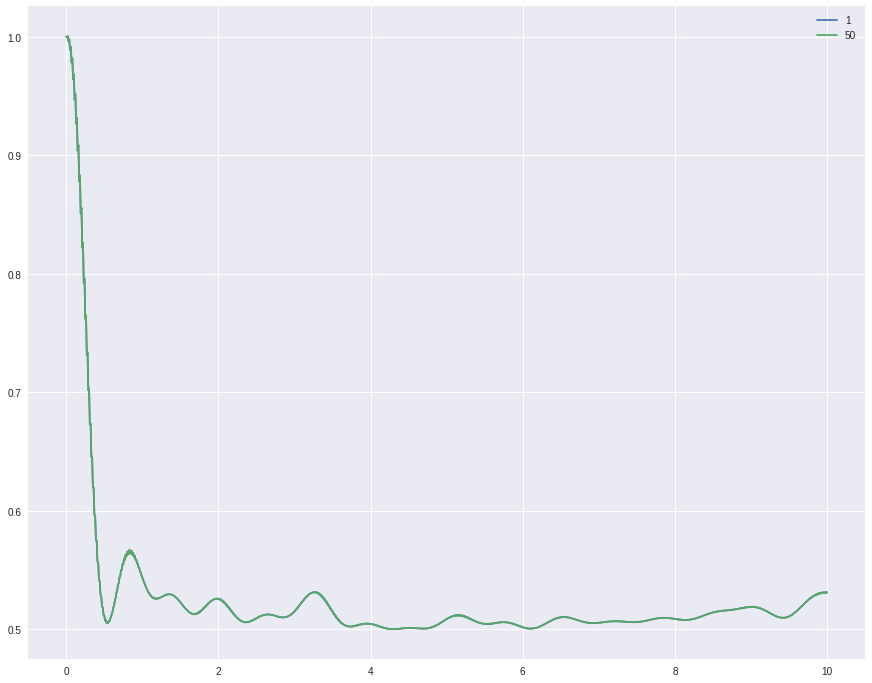

In [ ]:
dt=0.01
times=np.arange(0,10+dt,dt)
plt.figure(figsize=(15,12))
plt.plot(times, trace_values1[0], label='1')
plt.plot(times, trace_values1[49], label='50')
# plt.plot(times, trace_values1[199], label='200')
# plt.plot(times, trace_values1[499], label='500')
# plt.plot(times, trace_values1[999], label='1000')
plt.legend()